In [111]:
# Shiyi (Amy) Qin and Victor Z
# UW-Madison, 2024
# PCA estimation for Gibbs reactor

## Start here if working on google collab

---



In [112]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [113]:
# Specify the path of this file (This may differ for each user)
path = '/content/drive/MyDrive/StatsBookCode/Python/'

In [114]:
# This is to check if the speficied path above is correct
!echo $path
import os
os.path.isdir(path)

/content/drive/MyDrive/StatsBookCode/Python/


True

In [115]:
# This is needed so we can import packages from a different path than standard libraries
import sys
sys.path.append(path)

## Start from here if working on local computer

In [116]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv, eig
import pandas as pd

In [117]:
# Load the datasets
datat = np.loadtxt(path+'Data/gibbs_covariance.dat')
datan = np.loadtxt(path+'Data/gibbs_lowtemp_class.dat')
data = np.hstack((datat, datan[:, [0]]))

In [118]:
# Perturb data with noise
seed = 2024
np.random.seed(seed)  # For reproducibility
S, n = data.shape
data[:, 1] += np.random.normal(0, 0.05, S)

In [119]:
# Construct input-output matrices
Y = data[:, 1]
X = data[:, [0, 2, 3, 4, 5]]
X = np.hstack((np.ones((S, 1)),X))  # Add ones to introduce bias parameter

print(pd.DataFrame(X))

       0           1          2           3          4       5
0    1.0  166.977686  25.561388  451.122776  74.438612  583.15
1    1.0  170.710337  24.753476  449.506952  75.246524  583.15
2    1.0  141.174815  32.221642  464.443284  67.778358  583.15
3    1.0  146.628653  30.640396  461.280791  69.359604  583.15
4    1.0  164.665427  26.079611  452.159221  73.920389  583.15
..   ...         ...        ...         ...        ...     ...
245  1.0  155.382085  28.306396  456.612792  71.693604  583.15
246  1.0  128.563717  36.295215  472.590430  63.704785  583.15
247  1.0  123.361071  38.161599  476.323198  61.838401  583.15
248  1.0  148.630055  30.085281  460.170562  69.914719  583.15
249  1.0  173.032443  24.268076  448.536152  75.731924  583.15

[250 rows x 6 columns]


In [120]:
# Apply standard estimation
theta = np.linalg.solve(X.T @ X, X.T @ Y)
Yhat = X @ theta
e = Yhat - Y
MSE = np.mean(e**2)
sig2 = np.var(e)
Covtheta = sig2 * inv(X.T @ X)
diag_Covtheta = np.diag(Covtheta)
lamk = eig(X.T @ X)[0]

print(pd.DataFrame(theta))

          0
0  0.525581
1  0.000213
2 -0.041147
3  0.006609
4 -0.018131
5 -0.000675


In [121]:
# Apply PCA estimation
Sigma = X.T @ X
lam, W = eig(Sigma)
idx = lam.argsort()[::-1]
lam = lam[idx]
W = W[:, idx]

# Eliminate small eigenvalues
n1 = 3
W1 = -W[:, :n1]
L1 = np.diag(lam[:n1])

# Project input data
T1 = X @ W1

# Estimate parameters
gamma = np.linalg.solve(T1.T @ T1, T1.T @ Y)
thetan = W1 @ gamma
Yhatn = X @ thetan
en = Yhatn - Y
MSEn = np.mean(en**2)
sig2n = np.var(en)
Covthetan = sig2n * (W1 @ inv(L1) @ W1.T)
diag_Covthetan = np.diag(Covthetan)

print(pd.DataFrame(lam))

              0
0  1.454314e+08
1  2.362216e+05
2  1.973902e+03
3  5.495985e-10
4 -2.402845e-11
5 -3.903179e-08


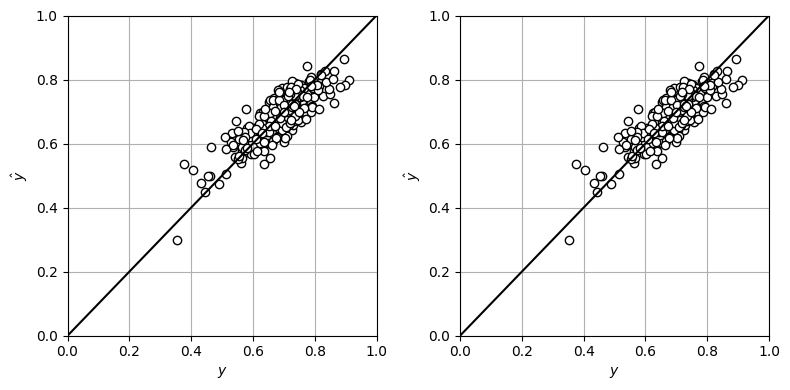

In [122]:
# Compare predictions and observations
fig, ax = plt.subplots(1, 2, figsize=(8,4))
xx = np.linspace(0, 1)

ax[0].plot(Y, Yhat, 'ko', markerfacecolor='w')
ax[0].plot(xx, xx, 'k')
ax[0].grid(True)
ax[0].set_xlabel('$y$')
ax[0].set_ylabel('$\\hat{y}$')
ax[0].set_xlim([0,1])
ax[0].set_ylim([0,1])


# Compare predictions and observations
ax[1].plot(Y, Yhatn, 'ko', markerfacecolor='w')
ax[1].plot(xx, xx, 'k')
ax[1].grid(True)
ax[1].set_xlabel('$y$')
ax[1].set_ylabel('$\\hat{y}$')
ax[1].set_xlim([0,1])
ax[1].set_ylim([0,1])

plt.tight_layout()


In [123]:
# Display results
print("Standard Estimation Results")
print("Theta:", theta)
print("MSE:", MSE)
print("Variance of errors:", sig2)
print("Covariance of theta:", diag_Covtheta)
print("Eigenvalues:", lamk)

print("\nPCA Estimation Results")
print("Theta (PCA):", thetan)
print("MSE (PCA):", MSEn)
print("Variance of errors (PCA):", sig2n)
print("Covariance of theta (PCA):", diag_Covthetan)
print("Eigenvalues (PCA):", lam[:n1])

Standard Estimation Results
Theta: [ 5.25580945e-01  2.12745187e-04 -4.11474888e-02  6.60866690e-03
 -1.81306154e-02 -6.74762170e-04]
MSE: 0.0025487966765476134
Variance of errors: 0.002548796676547614
Covariance of theta: [7.19815473e+09 3.32127090e-07 2.50481305e+07 6.39852225e+05
 1.14845424e+07 1.20443077e+04]
Eigenvalues: [ 1.45431359e+08  2.36221615e+05  1.97390155e+03 -3.90317870e-08
 -2.40284509e-11  5.49598494e-10]

PCA Estimation Results
Theta (PCA): [ 4.91546873e-06  2.12745187e-04 -2.20672795e-03 -2.44726841e-03
  2.69827483e-03  2.86645559e-03]
MSE (PCA): 0.002548796676547614
Variance of errors (PCA): 0.002548796676547614
Covariance of theta (PCA): [7.63446649e-13 3.32127090e-07 1.84185366e-07 2.59360199e-07
 2.66761424e-07 2.59620662e-07]
Eigenvalues (PCA): [1.45431359e+08 2.36221615e+05 1.97390155e+03]
